In [15]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import matplotlib.pyplot as plt

# Constantes
PATH_TO_ROOT = "../../"
PATH_DATA = PATH_TO_ROOT + "data/"
PATH_RAW = PATH_DATA + "raw/"
PATH_PROCESSED = PATH_DATA + "processed/"
PATH_EXTERNAL = PATH_DATA + "external/"
SEED = 123

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)

def change_format_hour(total_seconds):
    """Function to convert total seconds into hours, minutes and seconds format.
    Args:
        total_seconds (int): Total number of seconds to convert.
        
    Returns:
        None, but prints the formatted runtime in the following format: HH:MM:SS
    """
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    print(f"Total runtime: {hours:02d}:{minutes:02d}:{seconds:02d}s")


# Chargement des données

In [2]:
df = pd.read_csv(PATH_RAW + "x_train.csv", index_col=0)
df_target = pd.read_csv(PATH_RAW + "y_train.csv", index_col=0)
df[df_target.columns[0]] = df_target

df["text"] = np.where(
    df["description"].isna(),
    df["designation"].astype(str),
    df["designation"].astype(str) + " " + df["description"].astype(str),
)

df.drop("designation", axis=1, inplace=True)
df.drop("description", axis=1, inplace=True)
df.drop("productid", axis=1, inplace=True)
df.drop("imageid", axis=1, inplace=True)

display(df.head())
display(df.info())

,prdtypecode,text
0,10,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,2280,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,50,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,1280,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,2705,La Guerre Des Tuques Luc a des id&eacute;es de...


<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   prdtypecode  84916 non-null  int64 
 1   text         84916 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


None

In [3]:
value_counts = df["prdtypecode"].value_counts()
num_classes = value_counts.shape[0]
print("All classes:", value_counts.unique())
print(f"nombre de class : {num_classes}")

median = int(value_counts.quantile(0.5))
print("median :", median)

value_counts_index = value_counts[value_counts > median].index
print(value_counts_index)

All classes: [10209  5073  5045  4993  4989  4870  4774  4760  4303  3953  3241  3116
  2761  2671  2589  2508  2496  2491  2070  1681  1421   872   832   824
   807   803   764]
nombre de class : 27
median : 2671
Index([2583, 1560, 1300, 2060, 2522, 1280, 2403, 2280, 1920, 1160, 1320, 10,
       2705],
      dtype='int64', name='prdtypecode')


In [4]:
to_split = False

index_row = []
if to_split:
    for i in value_counts.index:
        if i in value_counts_index:
            index_row.extend(
                df.loc[df["prdtypecode"] == i].sample(n=median, random_state=123).index
            )
        else:
            index_row.extend(df.loc[df["prdtypecode"] == i].index)
else:
    index_row.extend(df.index)

data = df.loc[df.index.isin(index_row)]["text"]
target = df.loc[df.index.isin(index_row)]["prdtypecode"].astype("str")

print(data.shape)
print(target.shape)

(84916,)
(84916,)


In [5]:
from sklearn.calibration import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=SEED
)

X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Vectorize
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)

(67932, 27)


In [6]:
y_train_1d = np.argmax(y_train, axis=1)

# Appliquer des poids aux classes selon l'équilibrage du dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_1d), y=y_train_1d
)

# Create a dictionary mapping class indices to their corresponding weights
class_weight_dict = dict(zip(np.unique(y_train_1d), class_weights))

print(class_weight_dict)

print(X_train.shape)
print(y_train.shape)

{0: 1.0003976143141153, 1: 1.1873525247758376, 2: 0.7956989247311828, 3: 4.0256, 4: 0.6408558329088131, 5: 1.5202416918429003, 6: 0.6229264669472642, 7: 3.852986217457887, 8: 1.2668680765357503, 9: 0.965464313123561, 10: 0.6127618119824647, 11: 0.7320337503636892, 12: 4.006369426751593, 13: 0.6397152301042461, 14: 3.738484398216939, 15: 0.6628029504741834, 16: 0.6629776021080369, 17: 2.240427426536064, 18: 0.6296296296296297, 19: 1.2184019370460049, 20: 0.3081822635962763, 21: 1.2778059928897918, 22: 1.1307865168539326, 23: 3.5586987270155586, 24: 1.2375799311362519, 25: 1.8776119402985074, 26: 3.8353658536585367}
(67932, 1)
(67932, 27)


In [7]:
df["len"] = df["text"].str.len()
print("median:", df["len"].median())
print("mean:", df["len"].mean())

median: 314.0
mean: 595.3682933722738


# CNN
## PRE-PROCESSING

https://www.tensorflow.org/text/guide/word_embeddings?hl=fr

In [8]:
# Pour libérer de la RAM
del df, data, df_target, index_row, target

## Configurer l'ensemble de données pour les performances
Ce sont deux méthodes importantes que vous devez utiliser lors du chargement des données pour vous assurer que les E/S ne deviennent pas bloquantes.

- .cache() conserve les données en mémoire après leur chargement sur le disque. Cela garantira que l'ensemble de données ne devienne pas un goulot d'étranglement lors de la formation de votre modèle. Si votre jeu de données est trop volumineux pour tenir en mémoire, vous pouvez également utiliser cette méthode pour créer un cache sur disque performant, plus efficace à lire que de nombreux petits fichiers.

- .prefetch() chevauche le prétraitement des données et l'exécution du modèle pendant la formation.

Vous pouvez en savoir plus sur les deux méthodes, ainsi que sur la mise en cache des données sur le disque dans le guide des performances des données .

In [9]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
train_ds = X_train

# train_ds = tf.strings.as_string(X_train)
val_ds = tf.strings.as_string(X_test)

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(train_ds.shape)
print(val_ds.shape)

(67932, 1)
(16984, 1)


2024-04-15 16:57:20.872134: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-15 16:57:20.872155: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-15 16:57:20.872162: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-15 16:57:20.872180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 16:57:20.872193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# import mlflow

"""mlflow.set_tracking_uri("../mlruns")  # "http://127.0.0.1:8080"
mlflow.set_experiment(experiment_name="DecisionTreeClassifier_model")
mlflow.autolog(log_datasets=False)"""

'mlflow.set_tracking_uri("../mlruns")  # "http://127.0.0.1:8080"\nmlflow.set_experiment(experiment_name="DecisionTreeClassifier_model")\nmlflow.autolog(log_datasets=False)'

In [11]:
from keras.layers import TextVectorization
import string
import re


def custom_standardization(input_data):
    """
    Custom standardization function for text data.

    Args:
        input_data: The input text data.

    Returns:
        The standardized text data.
    """
    decoded_html = tf.strings.unicode_decode(input_data, "UTF-8")
    encoded_html = tf.strings.unicode_encode(decoded_html, "UTF-8")
    stripped_html = tf.strings.regex_replace(encoded_html, "<[^>]*>", " ")
    lowercase = tf.strings.lower(stripped_html)
    cleaned_input_data = tf.strings.regex_replace(lowercase, r"\s+", " ")
    return tf.strings.regex_replace(
        cleaned_input_data, "[%s]" % re.escape(string.punctuation), ""
    )


# Vocabulary size and number of words in a sequence.
# median = 320
# mean = 600
sequence_length = 600

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds
vectorize_layer.adapt(text_ds)
print("type:", type(text_ds), "  shape: ", text_ds.shape)

# SMOTE
# smote = SMOTE(random_state=SEED)
# text_ds, y_train = smote.fit_resample(text_ds, y_train)
# print("type:", type(text_ds), "  shape: ", text_ds.shape)

type: <class 'numpy.ndarray'>   shape:  (67932, 1)


## Utilisation de la couche Incorporation
Keras facilite l'utilisation des incorporations de mots. Jetez un œil à la couche Embedding .

La couche Embedding peut être comprise comme une table de correspondance qui mappe des indices entiers (qui représentent des mots spécifiques) à des vecteurs denses (leurs incorporations). La dimensionnalité (ou largeur) de l'incorporation est un paramètre que vous pouvez expérimenter pour voir ce qui fonctionne bien pour votre problème, de la même manière que vous expérimenteriez avec le nombre de neurones dans une couche Dense.

In [12]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from keras.layers import (
    Embedding,
    Dense,
    Bidirectional,
    Dropout,
    LSTM,
)
from keras import Sequential, losses, optimizers, utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [14]:
early_stopping = EarlyStopping(
    patience=10,  # Attendre n epochs avant application
    min_delta=0.005,  # si au bout de n epochs la fonction de perte ne varie pas de n %,
    # que ce soit à la hausse ou à la baisse, on arrête
    verbose=1,  # Afficher à quel epoch on s'arrête
    mode="min",
    monitor="val_loss",
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,  # si val_loss stagne sur n epochs consécutives selon la valeur min_delta
    min_delta=0.005,
    factor=0.2,  # On réduit le learning rate d'un facteur n
    cooldown=4,  # On attend n epochs avant de réitérer
    verbose=1,
)

In [15]:
model = Sequential(
    [
        vectorize_layer,
        Embedding(len(vectorize_layer.get_vocabulary()), 32, mask_zero=True),
        # Bidirectional(LSTM(16, return_sequences=True)),
        Bidirectional(LSTM(16)),
        Dense(16, activation="relu"),
        Dropout(0.5),
        Dense(num_classes),
    ]
)

optim = optimizers.Adam(0.001)
loss = losses.CategoricalCrossentropy()
# Compile the model
model.compile(
    optimizer=optim,
    loss=loss,
    metrics=["accuracy"],
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
training_history = model.fit(
    text_ds,
    y_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[reduce_learning_rate, early_stopping],
    class_weight=class_weight_dict,
)

In [ ]:
model.summary()

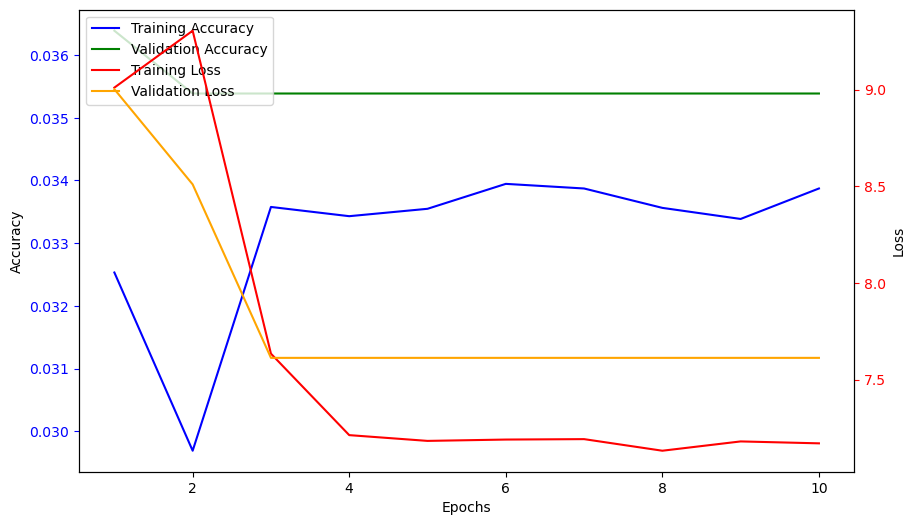

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

range_epochs = np.arange(1, len(training_history.epoch) + 1, 1)

# Courbe de la précision sur l'échantillon d'entrainement
ax.plot(
    range_epochs,
    training_history.history["accuracy"],
    label="Training Accuracy",
    color="blue",
)

ax.plot(
    range_epochs,
    training_history.history["val_accuracy"],
    label="Validation Accuracy",
    color="green",
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.tick_params("y", colors="blue")

# Courbe de la précision sur l'échantillon de test
ax2 = ax.twinx()
ax2.plot(
    range_epochs,
    training_history.history["loss"],
    label="Training Loss",
    color="red",
)
ax2.plot(
    range_epochs,
    training_history.history["val_loss"],
    label="Validation Loss",
    color="orange",
)
ax2.set_ylabel("Loss")
ax2.tick_params("y", colors="red")

# Affichage de la légende
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Affichage de la figure
plt.show()

In [22]:
t = "Starfield est un jeu de rôle et d'action de 2023 développé par Bethesda Game Studios et publié par Bethesda Softworks. Dans le jeu, le joueur rejoint un groupe d'explorateurs de l'espace qui doivent s'aventurer dans divers coins de la galaxie pour acquérir de mystérieux artefacts."
pred = model.predict(t)
pred  # normalement prdtypecode = 2462

ValueError: Unrecognized data type: x=Starfield est un jeu de rôle et d'action de 2023 développé par Bethesda Game Studios et publié par Bethesda Softworks. Dans le jeu, le joueur rejoint un groupe d'explorateurs de l'espace qui doivent s'aventurer dans divers coins de la galaxie pour acquérir de mystérieux artefacts. (of type <class 'str'>)

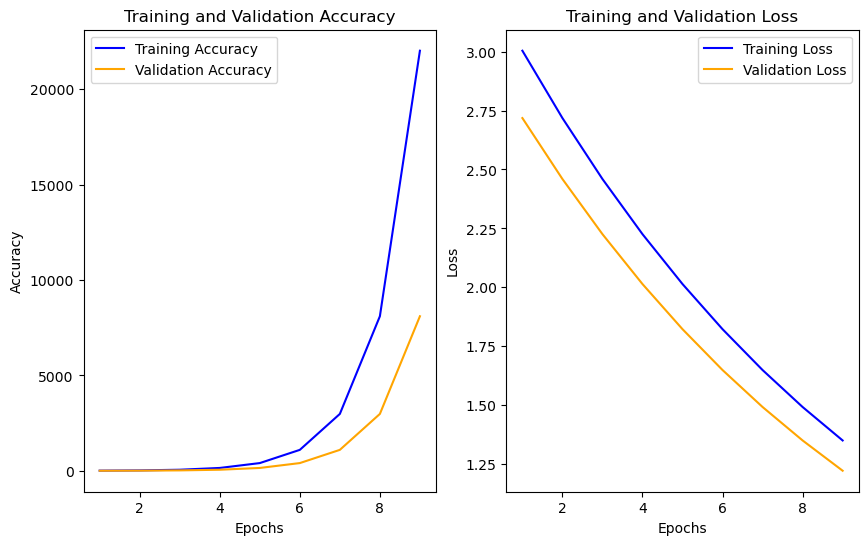

In [28]:
from matplotlib.pylab import exponential


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

range_epochs = np.arange(1, 9 + 1, 1)

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(
	range_epochs,
	np.exp(np.arange(2, 11, 1)),
	label="Training Accuracy",
	color="blue",
)

ax1.plot(
	range_epochs,
	np.exp(np.arange(1, 10, 1)),
	label="Validation Accuracy",
	color="orange",
)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training and Validation Accuracy")
ax1.legend()

# Courbe de la précision sur l'échantillon de test
ax2.plot(
	range_epochs,
	np.exp(np.arange(1.1, 0.2, -0.1)),
	label="Training Loss",
	color="blue",
)
ax2.plot(
	range_epochs,
	np.exp(np.arange(1, 0.1, -0.1)),
	label="Validation Loss",
	color="orange",
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Training and Validation Loss")
ax2.legend()

# Affichage de la figure
plt.show()